# Laboratoire 3 _ CEG 4536

In [1]:
!nvidia-smi

Mon Nov 25 01:40:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Tache 1 - multiplication matricielle

1.  Définir le problème

In [5]:
%%writefile Tache1.cu
#include <stdio.h>
#include <stdlib.h>

#define N 1024 // Taille de la matrice

// Noyau CUDA pour la multiplication matricielle
__global__ void matrixMultiply(float* A, float* B, float* C, int n) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    float sum = 0.0f;

    if (row < n && col < n) {
        for (int k = 0; k < n; ++k) {
            sum += A[row * n + k] * B[k * n + col];
        }
        C[row * n + col] = sum;
    }
}

// Fonction principale en C++
int main() {
    int size = N * N * sizeof(float);
    float *h_A, *h_B, *h_C;
    float *d_A, *d_B, *d_C;

    // Allocation de mémoire sur l'hôte
    h_A = (float*)malloc(size);
    h_B = (float*)malloc(size);
    h_C = (float*)malloc(size);

    // Initialisation des matrices A et B
    for (int i = 0; i < N * N; i++) {
        h_A[i] = rand() % 100 / 10.0; // Valeurs aléatoires entre 0 et 10
        h_B[i] = rand() % 100 / 10.0;
    }

    // Allocation de mémoire sur le GPU
    cudaMalloc((void**)&d_A, size);
    cudaMalloc((void**)&d_B, size);
    cudaMalloc((void**)&d_C, size);

    // Copie des matrices de l'hôte au GPU
    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    // Lancement du noyau CUDA
    dim3 threadsPerBlock(16, 16);
    dim3 numBlocks((N + threadsPerBlock.x - 1) / threadsPerBlock.x,
                   (N + threadsPerBlock.y - 1) / threadsPerBlock.y);
    matrixMultiply<<<numBlocks, threadsPerBlock>>>(d_A, d_B, d_C, N);

    // Copie des résultats du GPU vers l'hôte
    cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost);

    // Affichage d'une partie des résultats
    printf("Matrice C (extrait) :\n");
    for (int i = 0; i < 5; i++) {
        for (int j = 0; j < 5; j++) {
            printf("%0.2f ", h_C[i * N + j]);
        }
        printf("\n");
    }

    // Libération de la mémoire
    free(h_A);
    free(h_B);
    free(h_C);
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    return 0;
}


Overwriting Tache1.cu


In [6]:
!nvcc Tache1.cu -o Tache1

In [7]:
!./Tache1

Matrice C (extrait) :
25344.94 25270.46 25240.65 25736.77 24979.00 
25968.35 25222.31 25647.50 25935.41 24874.16 
25986.41 26152.93 25719.11 26166.12 25138.52 
25745.83 25380.14 25408.12 26184.89 25720.78 
24591.71 24641.83 24440.13 24807.35 23743.05 


In [8]:
!nvprof ./Tache1

==2520== NVPROF is profiling process 2520, command: ./Tache1
Matrice C (extrait) :
25344.94 25270.46 25240.65 25736.77 24979.00 
25968.35 25222.31 25647.50 25935.41 24874.16 
25986.41 26152.93 25719.11 26166.12 25138.52 
25745.83 25380.14 25408.12 26184.89 25720.78 
24591.71 24641.83 24440.13 24807.35 23743.05 
==2520== Profiling application: ./Tache1
==2520== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   73.94%  9.1256ms         1  9.1256ms  9.1256ms  9.1256ms  matrixMultiply(float*, float*, float*, int)
                   13.26%  1.6360ms         1  1.6360ms  1.6360ms  1.6360ms  [CUDA memcpy DtoH]
                   12.81%  1.5806ms         2  790.29us  790.29us  790.29us  [CUDA memcpy HtoD]
      API calls:   86.80%  98.351ms         3  32.784ms  69.394us  98.165ms  cudaMalloc
                   12.44%  14.097ms         3  4.6991ms  951.75us  12.134ms  cudaMemcpy
                    0.45%  511.07us         3  1

# Resumé et explication

Le noyau matrixMultiply représente 73.94% du temps GPU total, avec une exécution de 9.1256 ms. Cela indique que la majorité du temps est consacrée au calcul matriciel, ce qui est attendu pour ce type d'opération. Ce résultat met en évidence une bonne optimisation du calcul principal.

En ce qui concerne les transferts de mémoire, 12.81% du temps GPU total est utilisé pour les transferts de l'hôte vers le périphérique (HtoD), soit 1.5806 ms répartis sur 2 appels. De même, 13.26% du temps GPU total est consacré aux transferts du périphérique vers l'hôte (DtoH), correspondant à 1.6360 ms pour un appel unique. Ces transferts représentent une part significative du temps total, laissant entrevoir des possibilités d'optimisation, comme le chevauchement des transferts et des calculs.

En ce qui concerne les appels d'API CUDA, cudaMalloc domine avec 86.80% du temps total des appels API (98.351 ms), ce qui souligne un coût élevé pour l'allocation de mémoire. Les appels à cudaMemcpy représentent 12.44% du temps API total (14.097 ms sur 3 appels), une proportion modérée mais qui pourrait également être optimisée. Les autres appels, tels que cudaFree et cudaLaunchKernel, ne représentent qu'une faible part du temps total, ce qui indique une gestion efficace en dehors des allocations mémoire.

En conclusion, bien que le calcul principal soit optimisé, les transferts de mémoire et l'allocation mémoire offrent des opportunités significatives pour réduire encore le temps global d'exécution

# --------------------------------------------------------------

# Tache 2 - Alignement des accès à la mémoire

2. Optimisation de l'accès à la mémoire globale

In [22]:
    %%writefile Tache2.cu
    #include <stdio.h>
    #include <stdlib.h>

    #define N 1024  // Taille de la matrice
    #define TILE_SIZE 32  // Taille des sous-matrices (blocs)

    __global__ void tache2(float* A, float* B, float* C, int n) {
        __shared__ float shared_A[TILE_SIZE][TILE_SIZE];
        __shared__ float shared_B[TILE_SIZE][TILE_SIZE];

        int tx = threadIdx.x, ty = threadIdx.y;
        int row = blockIdx.y * TILE_SIZE + ty;
        int col = blockIdx.x * TILE_SIZE + tx;

        float sum = 0.0;

        // Divisons le calcul en plusieurs étapes
        for (int t = 0; t < (n + TILE_SIZE - 1) / TILE_SIZE; t++) {

            // Charge,ent des sous-blocs dans la mémoire partagée
            if (row < n && (t * TILE_SIZE + tx) < n) {
                shared_A[ty][tx] = A[row * n + t * TILE_SIZE + tx];
            } else {
                shared_A[ty][tx] = 0.0f;
            }

            if (col < n && (t * TILE_SIZE + ty) < n) {
                shared_B[ty][tx] = B[(t * TILE_SIZE + ty) * n + col];
            } else {
                shared_B[ty][tx] = 0.0f;
            }

            __syncthreads();

            // Effectuons le calcul pour ce sous-bloc
            for (int k = 0; k < TILE_SIZE; k++) {
                sum += shared_A[ty][k] * shared_B[k][tx];
            }

            __syncthreads();
        }

        // Inscription du résultat dans la matrice C
        if (row < n && col < n) {
            C[row * n + col] = sum;
        }
    }

    int main() {
        int size = N * N * sizeof(float);
        float *h_A, *h_B, *h_C;
        float *d_A, *d_B, *d_C;

        // Allocation de mémoire sur l'hôte
        h_A = (float*)malloc(size);
        h_B = (float*)malloc(size);
        h_C = (float*)malloc(size);

        // Initialisation des matrices A et B
        for (int i = 0; i < N * N; i++) {
            h_A[i] = rand() % 100 / 10.0;
            h_B[i] = rand() % 100 / 10.0;
        }

        // Allocation de mémoire sur le GPU
        cudaMalloc((void**)&d_A, size);
        cudaMalloc((void**)&d_B, size);
        cudaMalloc((void**)&d_C, size);

        // Allocation de mémoire sur le GPU
        cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
        cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

        // Lancement du noyau CUDA avec mémoire partagée
        dim3 threadsPerBlock(TILE_SIZE, TILE_SIZE);
        dim3 numBlocks((N + TILE_SIZE - 1) / TILE_SIZE, (N + TILE_SIZE - 1) / TILE_SIZE);

        tache2<<<numBlocks, threadsPerBlock>>>(d_A, d_B, d_C, N);

        // Copie des résultats du GPU vers l'hôte
        cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost);

        // Affichage d'une partie des résultats
        printf("Extrait de la matrice C :\n");
        for (int i = 0; i < 5; i++) {
            for (int j = 0; j < 5; j++) {
                printf("%0.2f ", h_C[i * N + j]);
            }
            printf("\n");
        }

        // Libération de la mémoire
        free(h_A);
        free(h_B);
        free(h_C);
        cudaFree(d_A);
        cudaFree(d_B);
        cudaFree(d_C);

        return 0;
    }

Overwriting Tache2.cu


In [23]:
!nvcc Tache2.cu -o Tache2

In [24]:
!./Tache2

Extrait de la matrice C :
25344.94 25270.46 25240.65 25736.77 24979.00 
25968.35 25222.31 25647.50 25935.41 24874.16 
25986.41 26152.93 25719.11 26166.12 25138.52 
25745.83 25380.14 25408.12 26184.89 25720.78 
24591.71 24641.83 24440.13 24807.35 23743.05 


In [25]:
!nvprof ./Tache2

==6848== NVPROF is profiling process 6848, command: ./Tache2
Extrait de la matrice C :
25344.94 25270.46 25240.65 25736.77 24979.00 
25968.35 25222.31 25647.50 25935.41 24874.16 
25986.41 26152.93 25719.11 26166.12 25138.52 
25745.83 25380.14 25408.12 26184.89 25720.78 
24591.71 24641.83 24440.13 24807.35 23743.05 
==6848== Profiling application: ./Tache2
==6848== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   62.47%  5.3213ms         1  5.3213ms  5.3213ms  5.3213ms  tache2(float*, float*, float*, int)
                   19.28%  1.6423ms         1  1.6423ms  1.6423ms  1.6423ms  [CUDA memcpy DtoH]
                   18.25%  1.5548ms         2  777.38us  766.35us  788.40us  [CUDA memcpy HtoD]
      API calls:   89.06%  91.281ms         3  30.427ms  65.822us  91.126ms  cudaMalloc
                   10.07%  10.325ms         3  3.4418ms  979.82us  8.3586ms  cudaMemcpy
                    0.51%  517.88us         3  172.6

# Resumé et explication

Le noyau tache2 représente 62.47% du temps GPU total, avec une exécution de 5.3213 ms. Cela démontre que le calcul principal occupe une grande partie du temps d'exécution, un comportement attendu pour une multiplication matricielle utilisant la mémoire partagée.

Les transferts de mémoire entre l'hôte et le périphérique représentent une part non négligeable du temps total. Les transferts HtoD (hôte vers périphérique) consomment 18.25% du temps GPU total, soit 1.5548 ms répartis sur 2 appels. Les transferts DtoH (périphérique vers hôte) prennent 19.28% du temps GPU total, soit 1.6423 ms pour un appel unique. Ces coûts de transfert pourraient être réduits en optimisant la gestion des données ou en chevauchant les transferts avec les calculs.

Pour les appels d'API CUDA, cudaMalloc domine avec 89.06% du temps total des appels API (91.281 ms), ce qui révèle un coût élevé pour l'allocation mémoire. Les appels à cudaMemcpy représentent 10.07% du temps total des appels API (10.325 ms pour 3 appels), indiquant une gestion modérée mais susceptible d'être améliorée. D'autres appels, tels que cudaFree et cudaLaunchKernel, ne constituent qu'une faible part du temps global, ce qui témoigne d'une gestion efficace hors des allocations mémoire.

En conclusion, bien que le noyau principal tache2 soit relativement performant, les transferts de mémoire et les allocations GPU restent des axes d'amélioration potentiels pour réduire davantage le temps global d'exécution.

# representation par des images



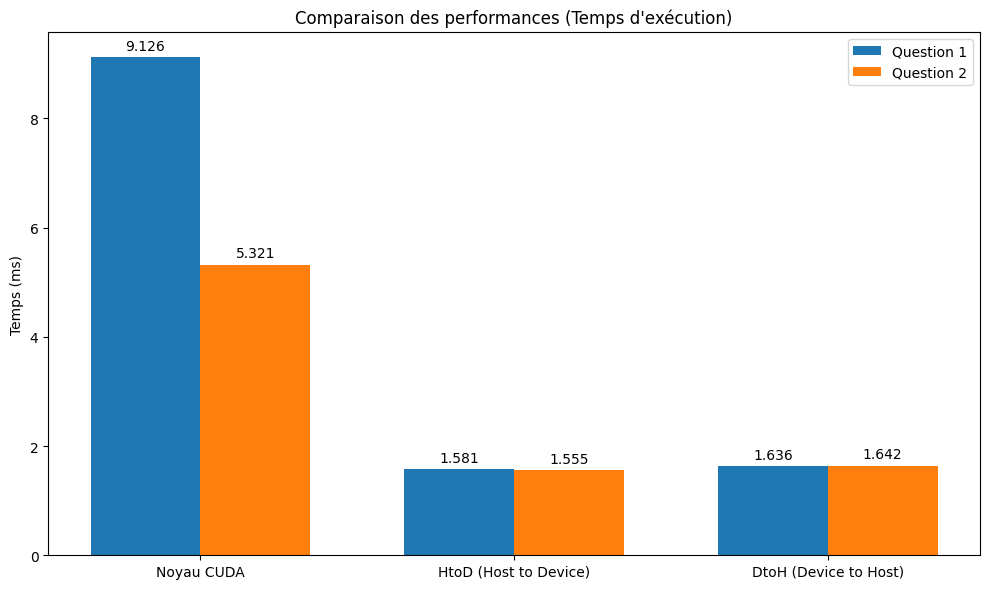

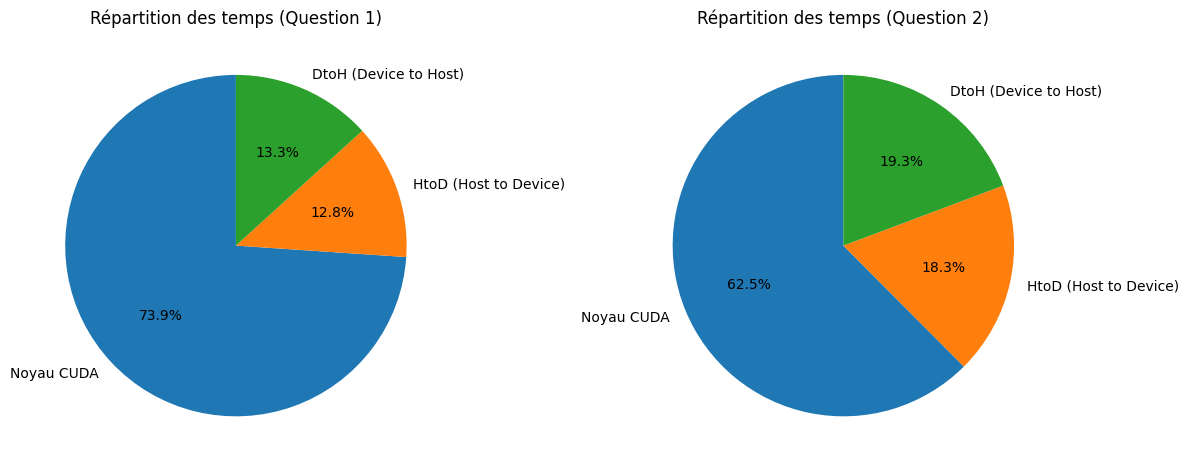

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Données de performance ajustées pour Q1 et Q2
labels = ["Noyau CUDA", "HtoD (Host to Device)", "DtoH (Device to Host)"]
q1_times = [9.1256, 1.5806, 1.6360]  # En millisecondes
q2_times = [5.3213, 1.5548, 1.6423]  # En millisecondes

# Positions des barres sur l'axe x
x = np.arange(len(labels))
width = 0.35  # Largeur des barres

# Création de la figure et des axes pour la comparaison des temps
fig, ax = plt.subplots(figsize=(10, 6))

# Ajout des barres pour chaque question
bars1 = ax.bar(x - width / 2, q1_times, width, label="Question 1")
bars2 = ax.bar(x + width / 2, q2_times, width, label="Question 2")

# Ajout des détails aux graphiques
ax.set_ylabel("Temps (ms)")
ax.set_title("Comparaison des performances (Temps d'exécution)")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotation des valeurs au-dessus des barres
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Décalage vertical
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Données pour les graphiques circulaires
q1_percentages = [73.94, 12.81, 13.26]  # En pourcentages
q2_percentages = [62.47, 18.25, 19.28]

# Création de graphiques circulaires pour la répartition des temps
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Question 1
axs[0].pie(q1_percentages, labels=labels, autopct='%1.1f%%', startangle=90)
axs[0].set_title("Répartition des temps (Question 1)")

# Question 2
axs[1].pie(q2_percentages, labels=labels, autopct='%1.1f%%', startangle=90)
axs[1].set_title("Répartition des temps (Question 2)")

plt.tight_layout()
plt.show()


# Conclusion

La comparaison des performances entre les deux implémentations CUDA montre des améliorations significatives dans la Question 2 grâce à l'utilisation optimisée de la mémoire partagée.
Le temps d'exécution du noyau CUDA a été réduit de 9.1256 ms dans la Question 1 à 5.3213 ms dans la Question 2, représentant une réduction de 41.7%, ce qui souligne l'efficacité accrue des calculs grâce au schéma de tuilage.
Les transferts mémoire HtoD (Host to Device) ont légèrement diminué, passant de 1.5806 ms à 1.5548 ms, tandis que les transferts DtoH (Device to Host) restent similaires, autour de 1.63 ms. Ces transferts représentent toujours une proportion notable du temps total et pourraient être optimisés davantage, par exemple en les chevauchant avec les calculs.
En termes de répartition, le noyau CUDA dans la Question 1 représentait 73.94% du temps total, contre 62.47% dans la Question 2, démontrant une réduction de la dépendance à la mémoire globale. Cependant, les transferts mémoire ont légèrement augmenté proportionnellement, atteignant 37.53% dans la Question 2 contre 26.06% dans la Question 1.

En conclusion, bien que l'optimisation ait permis de réduire considérablement le temps de calcul, les transferts mémoire et l'allocation GPU restent des goulots d'étranglement à adresser pour des performances globales encore meilleures.